In [34]:
using _Data, HDF5, PyCall, PyPlot, Statistics, NRRD, FileIO

In [2]:
@pyimport numpy

In [61]:
experimenter = "jen"
server = 9
experiment_filename ="20220406_111526"
analyzer = "chuyu"
    
ds = Dataset(experiment_filename, experimenter, gethostname() == "roli-$(server)" ? "/data" : "/nfs/data$(server)") # This example dataset is on roli-9, so the path is different depending on whether you're trying to access the file from roli-9
ds_save = Dataset(experiment_filename, analyzer, gethostname() == "roli-$(server)" ? "/data" : "/nfs/data$(server)")

C, heading, img_bg, y_fish, x_offset, x_fish, y_offset = h5open(ds, "behavior.h5"; raw = true) do file
    read(file, "C"),
    read(file, "heading"), 
    read(file, "img_bg"),
    read(file, "fish_anchor_y"), 
    read(file, "offset_x"), 
    read(file, "fish_anchor_x"), 
    read(file, "offset_y")
end;

w = size(img_bg, 1)
l = size(img_bg, 2);

#roi averged activity, which wasalready saved
NMF_filename = joinpath(data_path(ds_save), "NMF_merge.h5")
NMF_file = h5open(NMF_filename, "r")
A_dF = HDF5.readmmap(NMF_file["A_dF"]);
Z_all = read(NMF_file, "Z_all")
Y_all = read(NMF_file, "Y_all")
X_all = read(NMF_file, "X_all")
close(NMF_file)
n_neurons = size(A_dF, 2);
n_neuron = size(A_dF, 2);

In [29]:
#roi averged activity, which wasalready saved
NMF_filename = joinpath(data_path(ds), "NMF.h5")
NMF_file = h5open(NMF_filename, "r")
ds_stack_mean= Array(HDF5.readmmap(NMF_file["stack_mean"]));
close(NMF_file)

In [36]:
# ds_stack_mean[ds_stack_mean.<0] .= 0;

# img_save_path = data_path(ds_save)
# save(joinpath(img_save_path, experiment_filename*"_ds_stack_mean.nrrd"), ds_stack_mean)

In [26]:
size(ds_stack_mean)

(834, 490, 100)

In [5]:
NMF_filename = joinpath(data_path(ds_save), "NMF_merge.h5")
NMF_file = h5open(NMF_filename, "r")
global neuron_label = HDF5.readmmap(NMF_file["neuron_label"])
close(NMF_file)
n_neuron = n_neurons

# whether individual roi belongs to a certain region
region_bool_filename = joinpath(data_path(ds_save), "region_roi_bool.h5")
region_bool_file = h5open(region_bool_filename, "r")
global region_names = read(region_bool_file, "region_names")
global region_roi_bool = read(region_bool_file, "region_roi_bool")
close(region_bool_file)


# for one merged cell, it belongs to telecephalon if at least one of its roi belongs to telencephalon
region_roi_bool_pallium = region_roi_bool[:,findall(region_names .== "Telencephalon - Pallium")][:,1]
whether_pallum = falses(n_neuron)
for which_neuron in Int32.(numpy.unique(neuron_label)[1:end-1])
    if sum(region_roi_bool_pallium[neuron_label.==which_neuron]) >0
        whether_pallum[which_neuron] = true
    end
end

# for one merged cell, it belongs to telecephalon if at least one of its roi belongs to telencephalon
region_roi_bool_subpallium = region_roi_bool[:,findall(region_names .== "Telencephalon - Subpallium")][:,1]
whether_subpallum = falses(n_neuron)
for which_neuron in Int32.(numpy.unique(neuron_label)[1:end-1])
    if sum(region_roi_bool_subpallium[neuron_label.==which_neuron]) >0
        whether_subpallum[which_neuron] = true
    end
end

# for one merged cell, it belongs to telecephalon if at least one of its roi belongs to telencephalon
region_roi_bool_OB = region_roi_bool[:,findall(region_names .== "Telencephalon - Olfactory Bulb")][:,1]
whether_OB = falses(n_neuron)
for which_neuron in Int32.(numpy.unique(neuron_label)[1:end-1])
    if sum(region_roi_bool_OB[neuron_label.==which_neuron]) >0
        whether_OB[which_neuron] = true
    end
end

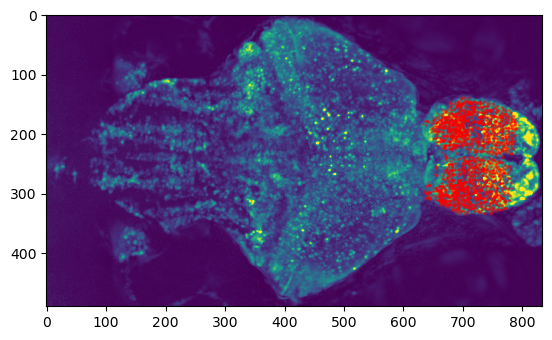

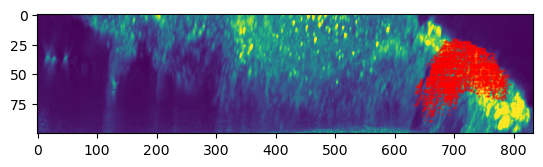

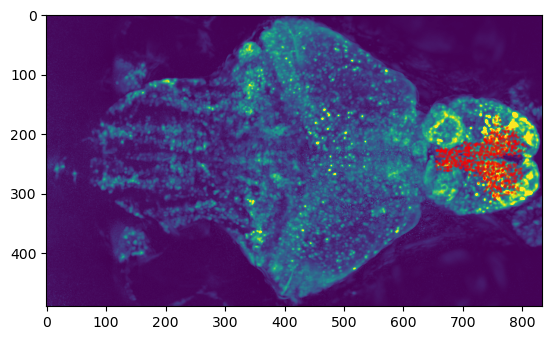

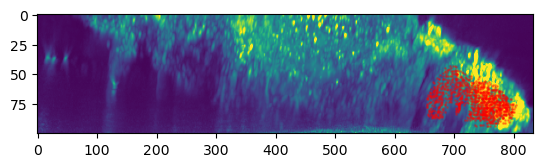

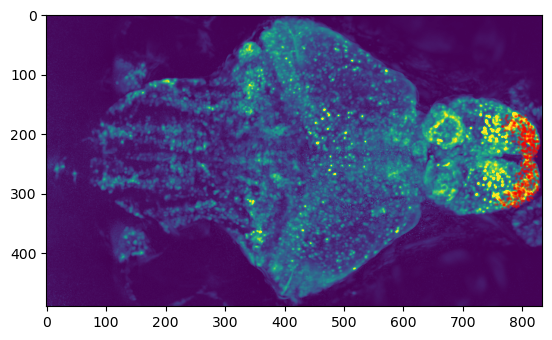

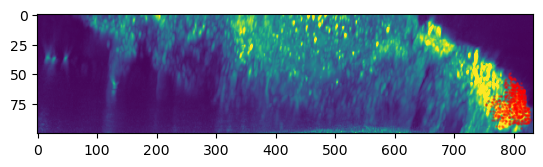

PyObject <matplotlib.image.AxesImage object at 0x7c05d839e3d0>

In [62]:
figure()
scatter(X_all[whether_pallum], Y_all[whether_pallum], s= 1, color="r", alpha = 0.3)
plt.imshow(numpy.max(ds_stack_mean, axis = 2)', vmax = 300)
figure()
scatter(X_all[whether_pallum], Z_all[whether_pallum], s= 1, color="r", alpha = 0.3)
plt.imshow(numpy.max(ds_stack_mean, axis = 1)', vmax = 300, aspect = 2)


figure()
scatter(X_all[whether_subpallum], Y_all[whether_subpallum], s= 1, color="r", alpha = 0.3)
plt.imshow(numpy.max(ds_stack_mean, axis = 2)', vmax = 300)
figure()
scatter(X_all[whether_subpallum], Z_all[whether_subpallum], s= 1, color="r", alpha = 0.3)
plt.imshow(numpy.max(ds_stack_mean, axis = 1)', vmax = 300, aspect = 2)


figure()
scatter(X_all[whether_OB], Y_all[whether_OB], s= 1, color="r", alpha = 0.3)
plt.imshow(numpy.max(ds_stack_mean, axis = 2)', vmax = 300)
figure()
scatter(X_all[whether_OB], Z_all[whether_OB], s= 1, color="r", alpha = 0.3)
plt.imshow(numpy.max(ds_stack_mean, axis = 1)', vmax = 300, aspect = 2)

In [65]:
function spherical_mask(volume_size::Tuple{Int, Int, Int}, 
                        center::Tuple{Float64, Float64, Float64}, 
                        radius::Float64, 
                        units::Tuple{Float64, Float64, Float64} = (1.0, 1.0, 2.0))
    nx, ny, nz = volume_size
    ux, uy, uz = units
    mask = falses(nx, ny, nz)
    
    for x in 1:nx, y in 1:ny, z in 1:nz
        dist2 = ((x - center[1]) * ux)^2 + ((y - center[2]) * uy)^2 + ((z - center[3]) * uz)^2
        if dist2 ≤ radius^2
            mask[x, y, z] = true
        end
    end
    
    return mask
end


spherical_mask (generic function with 2 methods)

In [68]:
vol_size = size(ds_stack_mean)  # Size of the 3D volume
target_center = (470.0, 162.0, 74.0) # Center of the sphere
radius = 50.0              # Radius of the sphere
use_mirror_target = true
target_mask = spherical_mask(vol_size, target_center, radius);

if use_mirror_target
    target_mask_mirror = reverse(target_mask, dims=2)
    target_mask = target_mask + target_mask_mirror
end;

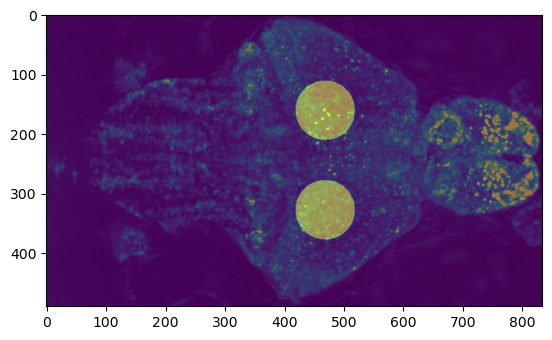

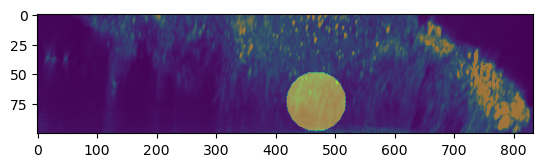

PyObject <matplotlib.image.AxesImage object at 0x7c05d8746940>

In [69]:
figure()
plt.imshow(numpy.max(ds_stack_mean, axis = 2)', vmax = 300)
plt.imshow(numpy.max(target_mask, axis = 2)', alpha = 0.5)
figure()
plt.imshow(numpy.max(ds_stack_mean, axis = 1)', vmax = 300, aspect = 2)
plt.imshow(numpy.max(target_mask, axis = 1)', alpha = 0.5, aspect = 2)

In [66]:
function corr_nan(trace1, trace2; at_least_overlap = 2)
    correlation = NaN
    valid_index = (.!isnan.(trace1)).*(.!isnan.(trace2)) #find the overlapping pixel indices
    if sum(valid_index) >= at_least_overlap
        correlation = cor(trace1[valid_index],trace2[valid_index]) #calculate correlation
    end
    return correlation
end

function corr_nan_matrix(matrix; at_least_overlap = 2)
    nr_variable = size(matrix, 2)
    corr_matrix = numpy.empty((nr_variable,nr_variable,))
    corr_matrix[:] .= numpy.nan
    i_j_combo = [(i,j) for i in 1:nr_variable for j in i+1:nr_variable]
    for (i,j) in i_j_combo
        vector_i = matrix[:, i]
        vector_j = matrix[:, j]
        corr_value = corr_nan(vector_i, vector_j; at_least_overlap = at_least_overlap)
        corr_matrix[i,j] = corr_value
        # corr_matrix[j,i] = corr_value
    end
    return corr_matrix
end

corr_nan_matrix (generic function with 1 method)

In [83]:
indices = CartesianIndex.(Int32.(round.(X_all)), Int32.(round.(Y_all)), Int32.(round.(Z_all)))

whether_PG = target_mask[indices];

In [84]:
pallium_cell_index = findall((whether_pallum).>0)
subpallium_cell_index = findall((whether_subpallum).>0)
ob_cell_index = findall((whether_OB).>0)
PG_cell_index = findall((whether_PG).>0)

telPG_cell_index = vcat(pallium_cell_index, subpallium_cell_index, ob_cell_index, PG_cell_index);

In [85]:
telPG_activity = A_dF[:,telPG_cell_index];

In [86]:
corr_activity = corr_nan_matrix(telPG_activity;at_least_overlap=500);

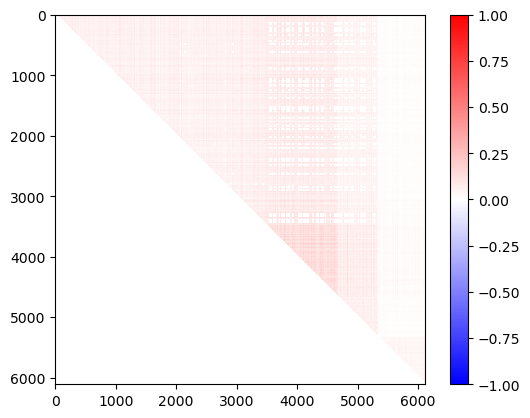

PyObject <matplotlib.colorbar.Colorbar object at 0x7c05d83498b0>

In [87]:
imshow(corr_activity, vmin = -1, vmax = 1, cmap="bwr")
colorbar()